<a href="https://colab.research.google.com/github/Ivan412/training/blob/main/6_python_advaced/4_reports%20and%20automation/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Продвинутый Python. Часть 4: отчеты и автоматизация. Работа с PDF.

---


#**Задание: сборка PDF документа**

Используя данные по посещаемости библиотек в районах Москвы

https://video.ittensive.com/python-advanced/data-7361-2019-11-28.utf.json

постройте круговую диаграмму суммарной посещаемости (NumOfVisitors) 20 наиболее популярных районов Москвы.

Создайте PDF отчет, используя файл

https://video.ittensive.com/python-advanced/title.pdf

как первую страницу. На второй странице выведите итоговую диаграмму, самый популярный район Москвы и число посетителей библиотек в нем.

In [1]:
%%capture
#скачаем титульню страницу и шрифт
!wget https://video.ittensive.com/python-advanced/title.pdf
!wget http://video.ittensive.com/python-advanced/Trebuchet.ttf

In [2]:
%%capture
#обновим модули
!pip install --upgrade Pillow PyPDF3 reportlab

In [3]:
#перезапустим рантайм
exit()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfgen import canvas
from reportlab.lib import pagesizes
from reportlab.lib.utils import ImageReader
from PyPDF3 import PdfFileMerger, PdfFileReader

In [5]:
#загрузим данные
data  = pd.read_json('https://video.ittensive.com/python-advanced/data-7361-2019-11-28.utf.json')
data = data[['NumOfVisitors', 'ObjectAddress']]

In [6]:
#найдем районы и откинем лишнее
data['District'] = ''
for ind, row in data.iterrows():
  data.at[ind, 'District'] = row['ObjectAddress'][0]['District'].replace('район', '')
data = data.drop(columns=['ObjectAddress'])
#проссуммируем посетителей по районам и возьмем топ-20
visitors = data.groupby('District').sum()['NumOfVisitors'].sort_values(ascending=False).iloc[0:20]

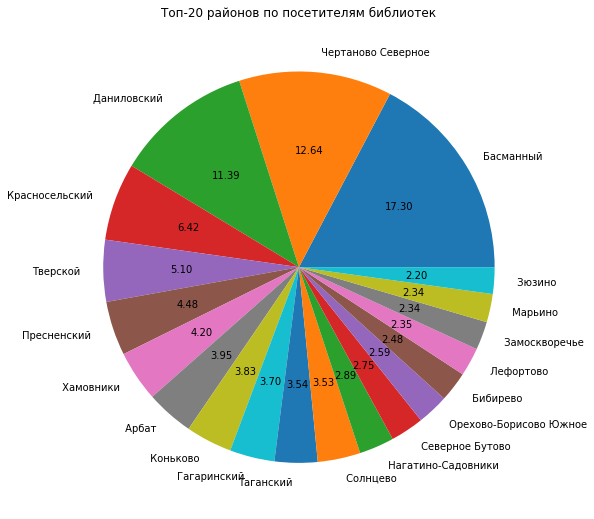

In [7]:
#построим круговую диаграмму и сохраним в файл
fig = plt.figure(figsize=(9, 9))
area = fig.add_subplot(1, 1, 1)
plt.title("Топ-20 районов по посетителям библиотек")
visitors.plot.pie(ax=area, label='', autopct='%.2f')
plt.savefig('visitors-20.png')

In [8]:
#нанесем диаграмму и надписи
pdfmetrics.registerFont(TTFont('Trebuchet', 'Trebuchet.ttf'))
PDF = canvas.Canvas('top_libraries.pdf', pagesize=pagesizes.A4)
PDF.setFont("Trebuchet", 14)
PDF.drawImage(ImageReader("visitors-20.png"), -30, 220)
PDF.drawString(30, 300, f"Самый популярный район: {visitors.index[0]}")
PDF.drawString(30, 280, f"Число посетителей - {visitors.iloc[0]}")
PDF.save()

#соеденим страницы в один документ
files = ["title.pdf", "top_libraries.pdf"]
merger = PdfFileMerger()
for filename in files:
  with open(filename, "rb") as pdf_file:
    merger.append(PdfFileReader(pdf_file))

#добавим метаданные
merger.addMetadata({
    '/Producer': "I. Morozov",
    '/Author': "I. Morozov",
    '/Creator': "I. Morozov - freze.special@gmail.com",
    '/Copyright': "2019",
    '/Title': "Культурная статистика Москвы"
})

merger.write("report.pdf")
